<img src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg">

# Journey to Data Scientist : le cas Ulule

### Import des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import csv
from scipy.stats import pearsonr,spearmanr


pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("./ulule_data.csv")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.head()

,absolute_url,address_required,amount_raised,analytics_count,background,comments_count,comments_enabled,committed,country,currency,currency_display,date_end,date_end_extra_time,date_goal_raised,date_start,delivery,description_ca,description_de,description_en,description_es,description_fr,description_funding_ca,description_funding_de,description_funding_en,description_funding_es,description_funding_fr,description_funding_it,description_funding_nl,description_funding_pt,description_it,description_nl,description_pt,description_yourself_ca,description_yourself_de,description_yourself_en,description_yourself_es,description_yourself_fr,description_yourself_it,description_yourself_nl,description_yourself_pt,discussions_thread_id,fans_count,finished,goal,goal_raised,id,image,is_cancelled,is_in_extra_time,is_online,lang,location,lowest_contribution_amount,main_image,main_tag,name_ca,name_de,name_en,name_es,name_fr,name_it,name_nl,name_pt,nb_days,nb_products_sold,news_count,orders_count,owner,payment_methods,percent,permissions,phone_number_required,required_personal_id_number,resource_uri,rewards,sharing_urls,slug,sponsorships_count,status,subtitle_ca,subtitle_de,subtitle_en,subtitle_es,subtitle_fr,subtitle_it,subtitle_nl,subtitle_pt,supporters_count,time_left,time_left_short,timezone,type,urls,user_role,video,visible
0,https://www.ulule.com/onaori/,False,520,0,"{'color': '', 'id': 1333735, 'url': 'https://s...",12,everyone,8,FR,EUR,€,2019-12-15T22:59:00Z,NaN,NaN,2019-10-22T00:00:00Z,"{'address_required': False, 'date_delivery': N...",NaN,NaN,NaN,NaN,<p><strong>DESCRIPTION : </strong></p>\n<p>Mon...,NaN,NaN,NaN,NaN,<p>Le financement me permettra de lancer la pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"<p><img src=""https://d2homsd77vx6d2.cloudfront...",NaN,NaN,NaN,693309.0,16,True,50,False,96490,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,False,False,True,fr,"{'city': 'Montigny-lès-Metz', 'country': 'FR',...",1.0,{'230x126': 'https://img.ulule.com/display/179...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,NaN,NaN,Pull bio éco-responsable pour sauver les balei...,NaN,NaN,NaN,50.0,8,2,7,{'absolute_url': 'https://www.ulule.com/onaori...,"['card', 'creditcard', 'saving']",16,"{'news': None, 'self': None}",False,False,https://api.ulule.com/v1/projects/96490,"[{'address_required': True, 'available': True,...","{'ca': 'https://fr.ulule.com/onaori/', 'de': '...",onaori,0,online,NaN,NaN,NaN,NaN,10% reversés pour l'achat d'un sweartshirt,NaN,NaN,NaN,7,NaN,NaN,Europe/Paris,1,{'web': {'checkout': 'https://www.ulule.com/pr...,NaN,NaN,True
1,https://www.ulule.com/i-falchi/,False,3415,0,"{'color': '', 'id': 1542930, 'url': 'https://s...",65,everyone,3415,IT,EUR,€,2020-09-30T21:59:00Z,NaN,2020-09-30T07:20:33.974135Z,2020-08-03T00:00:00Z,"{'address_required': False, 'date_delivery': '...",NaN,NaN,"<p style=""text-align: justify;"">Here we go aga...",NaN,NaN,NaN,NaN,<p>The funds raised will cover all the product...,NaN,NaN,<p>I fondi raccolti andranno a coprire tutti i...,NaN,NaN,"<p style=""text-align: justify;"">Eccoci di nuov...",NaN,NaN,NaN,NaN,"<p style=""text-align: center;""><strong>DIRECTO...",NaN,NaN,"<p style=""text-align: center;""><strong>REGISTA...",NaN,NaN,745895.0,50,True,3000,True,111165,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,False,False,True,it,"{'city': 'Bolzano - Bozen', 'country': 'IT', '...",1.0,{'230x126': 'https://img.ulule.com/display/6e6...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,THE HAWKS,NaN,NaN,I FALCHI,NaN,NaN,NaN,52,7,52,{'absolute_url': 'https://www.ulule.com/lilian...,"['card', 'creditcard', 'paypal', 'saving']",113,"{'news': None, 'self': None}",False,False,https://api.ulule.com/v1/projects/111165,"[{'address_required': False, 'available': True...","{'ca': 'https://it.ulule.com/i-falchi/', 'de':...",i-falchi,0,online,NaN,NaN,a film by Lilian Sassanelli,NaN,NaN,un film di Lilian Sassanelli,NaN,NaN,46,NaN,NaN,Europe/Paris,2,{'web': {'checkout': 'https://www.ulule.com/pr..

### Vérification du set de données

Dans la mesure où certains projets peuvent ou non avoir une vidéo de présentation, il est exclu de retirer toute ligne contenant un "NaN" représentant un vide.

In [4]:
data.drop_duplicates(inplace=True)  # Retrait de doublons.
data = data.loc[:, (data != data.iloc[0]).any()]  # Retrait de colonnes constantes

In [5]:
def retrait_elt_inutiles(axis):
    """
    Retire les lignes inutiles si axis=0;
    les colonnes si axis=1.
    """
    
    # Attention à ne pas retirer d'éléments lors d'un parcours basé sur des indices...
    to_be_dropped = []
    for index, is_elt_useful in enumerate(data.any(axis=((axis + 1) % 2))):
        if not is_elt_useful:
            print("La {} \"{}\" est retirée.".format("colonne" if axis else "ligne", data.columns[index]))
            to_be_dropped.append(index)

    data.drop(data.columns[to_be_dropped], axis=axis, inplace=True)

    if not data.any(axis=((axis + 1) % 2)).all():
        print("Erreur probable lors du retrait des colonnes !")

Les lignes ou les colonnes vides peuvent être retirées.

#### Retrait de colonnes inutiles

In [6]:
retrait_elt_inutiles(1)

La colonne "user_role" est retirée.


#### Retrait de lignes inutiles

In [7]:
retrait_elt_inutiles(0)

#### Retrait de colonnes quasi vides

Attention ! Le traitement suivant a été fait à l'aide d'un sous-échantillon du set de données, il faut donc vérifier si le retrait de ces colonnes est toujours pertinent.
De plus il est possible que certaines colonnes qui étaient vides ou constantes ne le soient plus et doivent être ajoutées ici.

In [78]:
data

,amount_raised,analytics_count,background,comments_count,committed,date_end_extra_time,date_goal_raised,date_start,description_fr,description_funding_fr,description_yourself_fr,fans_count,finished,goal,goal_raised,id,image,location,main_image,main_tag,name_fr,nb_days,news_count,owner,payment_methods,percent,rewards,sponsorships_count,subtitle_fr,supporters_count,type,video,visible,news_per_days
0,520,0,"{'color': '', 'id': 1333735, 'url': 'https://s...",12,8,NaN,NaN,2019-10-22T00:00:00Z,<p><strong>DESCRIPTION : </strong></p>\n<p>Mon...,<p>Le financement me permettra de lancer la pr...,"<p><img src=""https://d2homsd77vx6d2.cloudfront...",16,True,50,False,96490,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,"{'city': 'Montigny-lès-Metz', 'country': 'FR',...",{'230x126': 'https://img.ulule.com/display/179...,{'absolute_url': 'https://www.ulule.com/catego...,Pull bio éco-responsable pour sauver les balei...,50.0,2,{'absolute_url': 'https://www.ulule.com/onaori...,"['card', 'creditcard', 'saving']",16,"[{'address_required': True, 'available': True,...",0,10% reversés pour l'achat d'un sweartshirt,7,1,NaN,True,0.040000
1,3415,0,"{'color': '', 'id': 1542930, 'url': 'https://s...",65,3415,NaN,2020-09-30T07:20:33.974135Z,2020-08-03T00:00:00Z,NaN,NaN,NaN,50,True,3000,True,111165,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,"{'city': 'Bolzano - Bozen', 'country': 'IT', '...",{'230x126': 'https://img.ulule.com/display/6e6...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,7,{'absolute_url': 'https://www.ulule.com/lilian...,"['card', 'creditcard', 'paypal', 'saving']",113,"[{'address_required': False, 'available': True...",0,NaN,46,2,NaN,True,0.000000
2,480,0,"{'color': '#adc4e3', 'id': 1329113}",6,6,NaN,2019-10-29T14:48:38.352985Z,2019-10-17T00:00:00Z,<p>En avant première découvrez notre collectio...,<p>Moea a fêté cette année ces 2ans! 2ans de d...,"<p>Notre collection 2020 s'intitule Pachamama,...",6,True,5,True,96208,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,"{'city': 'Montpellier', 'country': 'FR', 'full...",{'230x126': 'https://img.ulule.com/display/fa9...,{'absolute_url': 'https://www.ulule.com/catego...,Pré-ventes Moea Swimwear!,20.0,0,{'absolute_url': 'https://www.ulule.com/evaber...,"['card', 'creditcard', 'saving']",120,"[{'address_required': True, 'available': True,...",0,Maillots de bain éco responsables,6,1,"{'author_name': 'Eva Bernard', 'author_url': '...",True,0.000000
3,10015,1,"{'color': '#e8eefc', 'id': 1475391, 'url': 'ht...",123,10015,NaN,2020-07-31T09:15:54.364325Z,2020-05-20T00:00:00Z,"<p style=""text-align: center;""><img src=""https...","<p style=""text-align: center;""><img src=""https...","<p style=""text-align: center;""><img src=""https...",102,True,10000,True,107745,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,"{'city': 'Clamart', 'country': 'FR', 'full_nam...",{'230x126': 'https://img.ulule.com/display/c01...,{'absolute_url': 'https://www.ulule.com/catego...,IlFautSauver! Des solutions écologiques concrètes,NaN,11,{'absolute_url': 'https://www.ulule.com/il_fau...,"['card', 'creditcard', 'saving']",100,"[{'address_required': False, 'available': True...",0,Soutenez un projet collaboratif et positif pou...,97,2,{'author_name': 'Nicolas Plain - Explorateur S...,True,0.000000
4,1324,0,NaN,25,1324,NaN,2020-12-03T06:35:25.889343Z,2020-11-18T00:00:00Z,<p><u><strong>Ouverture de votre nouveau studi...,<p>​Pour nous aider dans notre projet (en cett...,"<p>Alexis Fouquet et Erwan Beunet, nous sommes...",31,True,1000,True,118530,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,"{'city': 'Rennes', 'country': 'FR', 'full_name...",{'230x126': 'https://img.ulule.com/display/0a2...,{'absolute_url': 'https://www.ulule.com/catego...,STUDIO DE COACHING ALEXIS ET ERWAN,40.0,0,{'absolute_url': 'https://www.ulule.com/alexis...,"['card', 'creditcard', 'saving']",132,"[{'address_required': False, 'available': True...",0,OUVERTURE A RENNES LE 04/01/2021 - 1er palier ...,31,2,NaN,True,0.000000
5,5175,0,

Les colonnes "country", description_en", "description_es", "description_funding_en", "description_funding_es", "description_it", "description_funding_it", "description_yourself_en", "description_yourself_es", "description_yourself_it", "lang", "name_en", "name_es", "name_it", "subtitle_en", "subtitle_es", "subtitle_it" sont quasi vides. De manière générale, les projets sont en écrasante majorité uniquement en français.
"absolute_url", l'URL d'un projet est retirée car non pertinente.
"is_cancelled" est bien sûr retiré car un projet annulé n'a aucune chance d'être un succès.


"image" est laissée, et pourra être binarisée (avoir une image ou non) ?
"sponsorships_count" est quasi vide mais gardée car intéressante, pareil pour "fans_count"
"id" est conservée pour l'affichage de graphes
Les colonnes "orders_count" et "nb_products_sold" semblent identiques, il faudra surement en retirer une
Les colonnes "amount_raised" et "committed" semblent identiques, il faudra surement en retirer une
Les colonnes "nb_products_sold" et "supporters_count" semblent identiques car en écrasante majorité les investisseurs ne souhaitent qu'une seule contrepartie. 

Ajout de colonnes :
nombre de new/nombre de jour de campagne
l'id du main_tag

In [8]:
data.drop(["country", "description_en", "description_es", "description_funding_en", "description_funding_es", "description_it", "description_funding_it", "description_yourself_en", "description_yourself_es", "description_yourself_it", "is_cancelled", "lang", "name_en", "name_es", "name_it", "subtitle_en", "subtitle_es", "subtitle_it", "absolute_url"], axis=1, inplace=True)

In [77]:
data.drop(columns=['address_required', 'phone_number_required', 'comments_enabled', 'currency', 'currency_display', 'date_end', 
'delivery', 'description_ca', 'description_de', 'description_funding_ca', 'description_funding_de', 
'description_funding_nl', 'description_funding_pt', 'description_nl', 'description_pt', 'description_yourself_ca', 
'description_yourself_de', 'description_yourself_nl', 'description_yourself_pt', 'discussions_thread_id', 'is_in_extra_time', 
'lowest_contribution_amount', 'name_ca', 'name_de', 'name_nl', 'name_pt', 'nb_products_sold', 'orders_count', 
'required_personal_id_number', 'resource_uri', 'sharing_urls', 'slug', 'subtitle_ca', 'subtitle_de', 'subtitle_nl', 'subtitle_pt', 
'time_left', 'time_left_short', 'timezone', 'urls'], inplace=True)

### Statistiques descriptives

In [9]:
def pie_feature(feature_name, title):
    plt.figure()
    plt.suptitle(title)
    valeurs = data[feature_name].value_counts() #on compte le nombre de personnes qui ont chaque feature
    plt.pie(valeurs, labels=valeurs.index,autopct='%1.2f%%')
    plt.show()
    
def plot_feature(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

##### fans_count

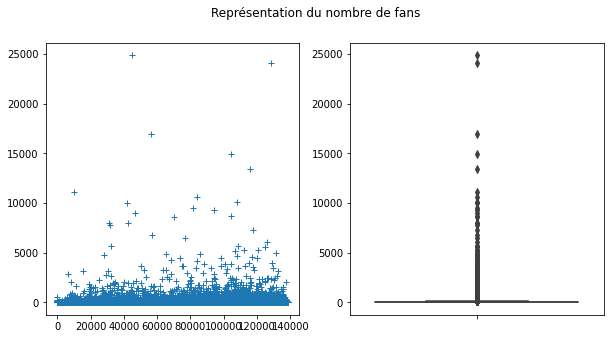

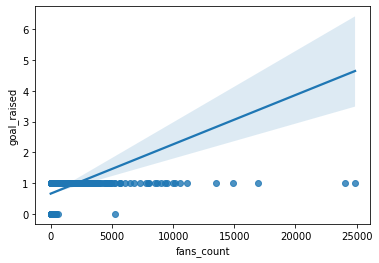

SpearmanrResult(correlation=0.26279190707761285, pvalue=0.0)

In [11]:
plot_feature("fans_count", "Représentation du nombre de fans","","")

plt.figure()
sns.regplot(x="fans_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['fans_count'])

La présence de fans semble être un phénomène très minoritaire, il serait intéressant de vérifier si les projets suivis ont été plus réussis que les autres.
Il est possible de conclure quand à l'existence d'une corrélation entre le succès de la campagne et le nombre de fans.

##### goal_raised

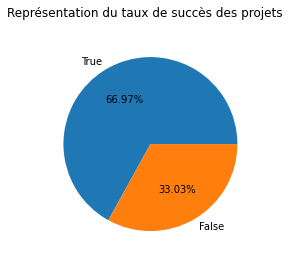

In [12]:
plt.figure()
plt.suptitle("Représentation du taux de succès des projets")
valeurs = data["goal_raised"].value_counts() #on compte le nombre de personnes qui ont chaque feature
plt.pie(valeurs, labels=valeurs.index,autopct='%1.2f%%')
plt.show()

Pour rappel, le taux de succès des projets de la plateforme en 2021 est de 79%.

##### payment_methods

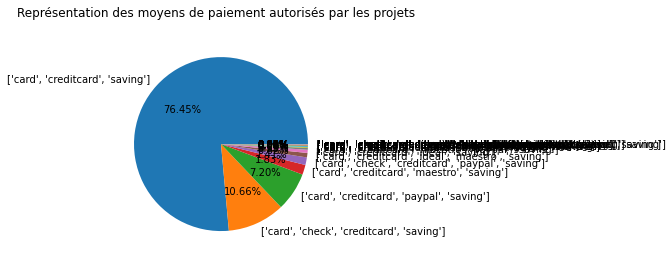

SpearmanrResult(correlation=nan, pvalue=nan)

In [17]:
pie_feature("payment_methods", "Représentation des moyens de paiement autorisés par les projets")

"""plt.figure(figsize=(10,5))
plt.plot(data.payment_methods, data.goal_raised, "+")
plt.suptitle("Succès de la campagne en fonction des moyens de paiement autorisés")
plt.xlabel("Moyens de paiement")
plt.ylabel("Succès de la campagne")
plt.show()"""

spearmanr(data['goal_raised'], data['payment_methods'])

La totalité autorise le trio "card, creditcard, saving" et 75% l'utilisent.
Il ne semble y avoir aucune corrélation entre le moyen de paiement et le succès de la campagne.

##### sponsorships_count

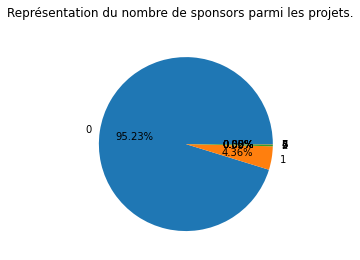

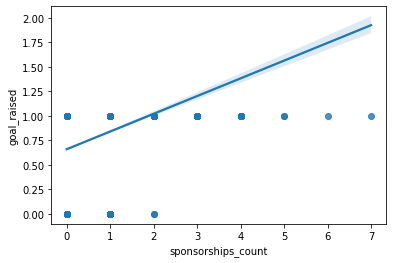

SpearmanrResult(correlation=0.09752584204308992, pvalue=1.626635586632257e-110)

In [20]:
pie_feature("sponsorships_count", "Représentation du nombre de sponsors parmi les projets.")

plt.figure()
sns.regplot(x="sponsorships_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['sponsorships_count'])

L'obtention de sponsors semble être un phénomène très minoritaire.
Il ne semble pas y avoir de corrélation entre le succès de la campagne et la présence de sponsors.

##### main_tag

In [22]:
"""tag_list = [ast.literal_eval(data["main_tag"][k])["id"] for k in range(len(data["main_tag"]))]
valeurs = data["main_tag"].value_counts() #on compte le nombre de personnes qui ont chaque feature
index_list = [ast.literal_eval(k)['id'] for k in valeurs.index]

plt.figure()
plt.suptitle("Représentation des id des main_tag des projets.")
plt.pie(valeurs, labels=index_list, autopct='%1.2f%%')
plt.show()

data["main_tag_id"] = tag_list"""

spearmanr(data['goal_raised'], data['main_tag'])

SpearmanrResult(correlation=nan, pvalue=nan)

Il ne semble pas y avoir une corrélation entre le tag du projet et son succès.

##### amount_raised

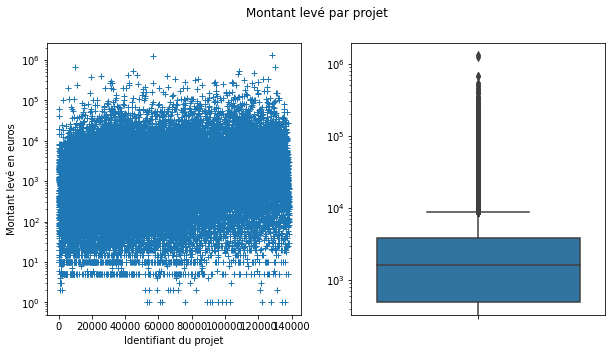

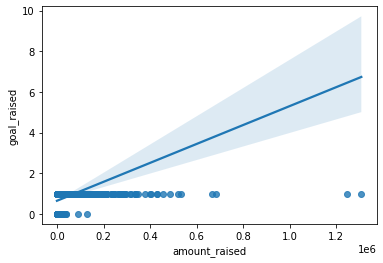

SpearmanrResult(correlation=0.6718082802392161, pvalue=0.0)

In [29]:
def plot_feature_log(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

plot_feature_log("amount_raised", "Montant levé par projet", "Identifiant du projet", "Montant levé en euros")

plt.figure()
sns.regplot(x="amount_raised", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['amount_raised'])

Les projets semblent assez homogènes dans les montants levés même si moins nombreux pour les plus hauts montants.
Il semble y avoir une bonne corrélation entre le montant obtenu et le succès de la campagne (peu surprenant).

##### comments_count

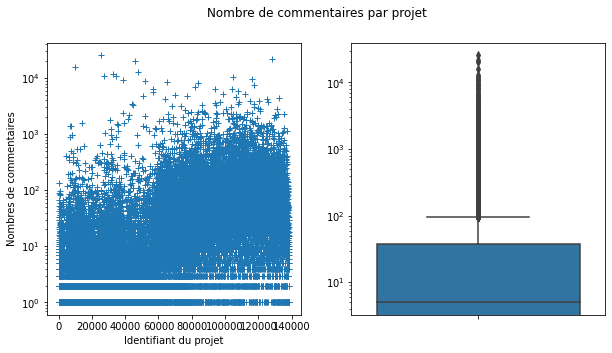

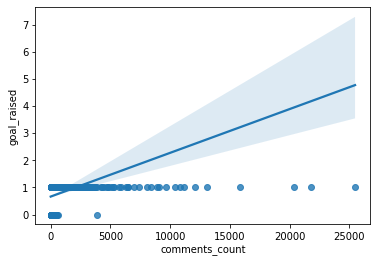

SpearmanrResult(correlation=0.370670103808613, pvalue=0.0)

In [31]:
plot_feature_log("comments_count", "Nombre de commentaires par projet", "Identifiant du projet", "Nombres de commentaires")

plt.figure()
sns.regplot(x="comments_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['comments_count'])

Les projets reçoivent globalement assez peu de commentaires. La plupart des projets qui ont beaucoup de commentaires, ont bien fonctionné.
Il semble y avoir une petite corrélation entre le nombre de commentaires et le succès de la campagne.

##### goal

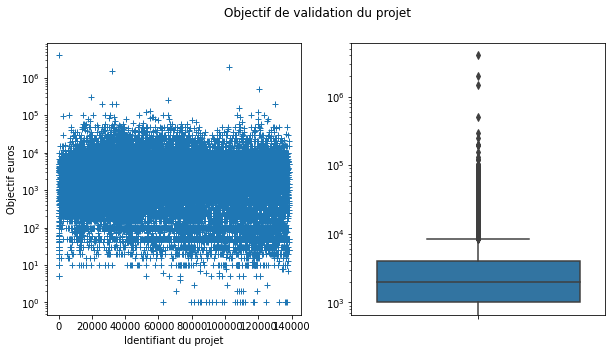

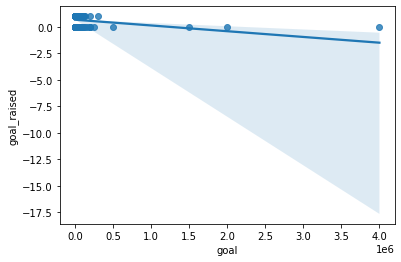

SpearmanrResult(correlation=-0.08648727400095113, pvalue=3.07554929445736e-87)

In [33]:
plot_feature_log("goal", "Objectif de validation du projet", "Identifiant du projet", "Objectif euros")

plt.figure()
sns.regplot(x="goal", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['goal'])

La majorité des projets semble se concentrer autour de la même fourchette de valeur, malgré quelques valeurs extrêmes.
Il ne semble pas y avoir de corrélation entre le montant de succès de la campagne et son succès.

##### nb_days

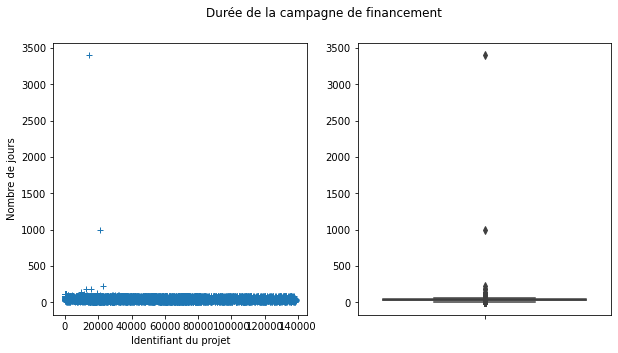

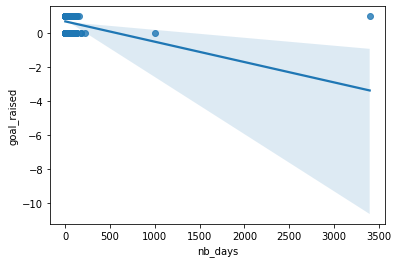

SpearmanrResult(correlation=nan, pvalue=nan)

In [34]:
plot_feature("nb_days", "Durée de la campagne de financement", "Identifiant du projet", "Nombre de jours")

plt.figure()
sns.regplot(x="nb_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['nb_days'])

Les campagnes semblent durer plus ou moins un mois en grande majorité.
Il ne semble n'y avoir aucune corrélation entre la durée de la campagne et son succès.

##### news_count

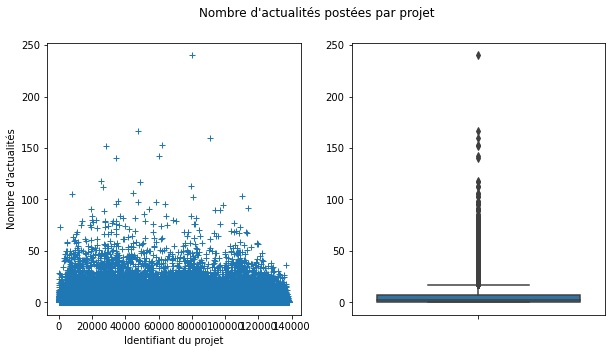

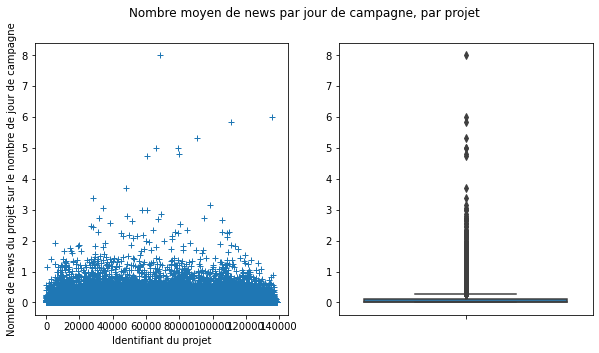

/home/ratpikebab/.local/lib/python3.8/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ratpikebab/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/ratpikebab/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


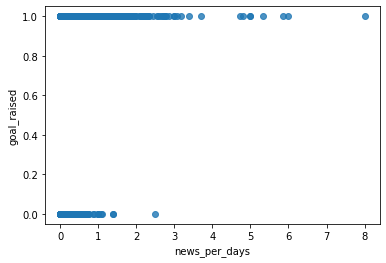

SpearmanrResult(correlation=0.29265442121775204, pvalue=0.0)

In [35]:
plot_feature("news_count", "Nombre d'actualités postées par projet", "Identifiant du projet", "Nombre d'actualités")
col = (data["news_count"]/data["nb_days"]).apply(lambda x : 0 if np.isnan(x) else x)
data["news_per_days"] = col

plot_feature("news_per_days", "Nombre moyen de news par jour de campagne, par projet","Identifiant du projet","Nombre de news du projet sur le nombre de jour de campagne")

plt.figure()
sns.regplot(x="news_per_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['news_per_days'])

Un certain nombre de projets ne donne aucune nouvelle durant la campagne, la grande majorité n'en donne pas plus de cinq durant toute la campagne. La grande majorité des projets ne donne qu'une news tous les dix jours, au mieux.
Il semble y avoir une légère corrélation entre le nombre de news par jour et le succès de la campagne.

##### percent

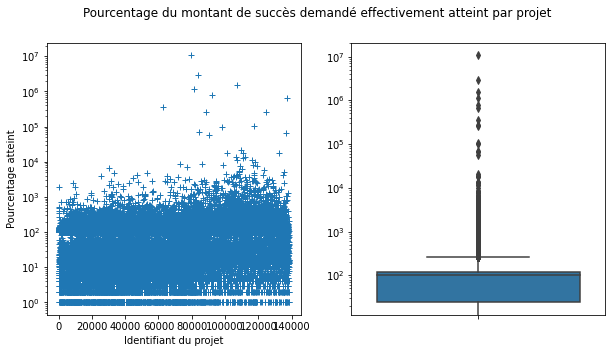

In [37]:
plot_feature_log("percent", "Pourcentage du montant de succès demandé effectivement atteint par projet", "Identifiant du projet", "Pourcentage atteint")

On note trois catégories de projets : 
- ceux qui échouent complétement (moins de 50% du montant demandé sont atteints)
- ceux qui réussissent "normalement" (entre 100% et 175% du montant demandé sont atteints)
- ceux qui réussissent "fortement" (au-delà de 200%)

##### supporters_count

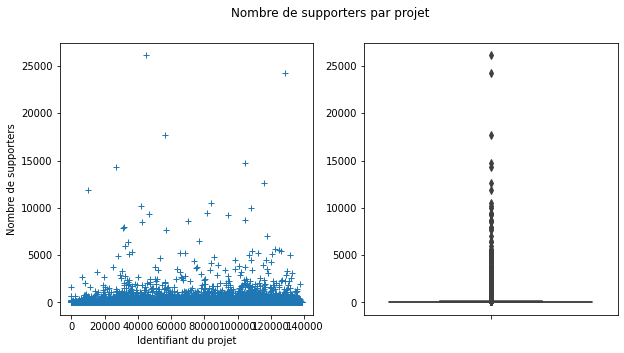

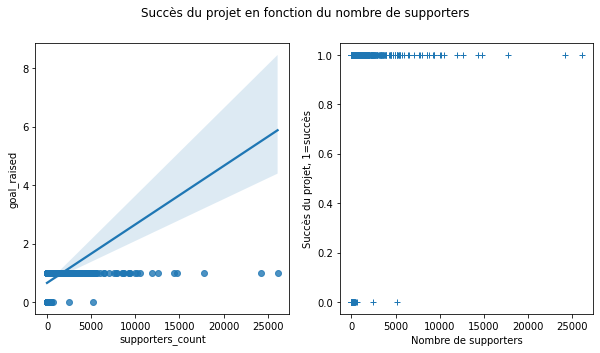

SpearmanrResult(correlation=0.684091729304795, pvalue=0.0)

In [38]:
plot_feature("supporters_count", "Nombre de supporters par projet", "Identifiant du projet", "Nombre de supporters")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="supporters_count", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction du nombre de supporters")
ax2.set_xlabel("Nombre de supporters")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.supporters_count, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['supporters_count'])

On constate une bonne corrélation entre le succès du projet et le nombre de supporters.

## Enlever les extrêmes

On va enlever les colonnes pour: address_required, phone_number_required, comments_enabled, currency, currency_display, date_end, delivery, description_ca, description_de, description_funding_ca, description_funding_de, description_funding_nl, description_funding_pt, description_nl, description_pt, description_yourself_ca, description_yourself_de, description_yourself_nl, description_yourself_pt, discussions_thread_id, is_in_extra_time, lowest_contribution_amount, name_ca, name_de, name_nl, name_pt, nb_products_sold, orders_count, required_personal_id_number, resource_uri, sharing_urls, slug, subtitle_ca, subtitle_de, subtitle_nl, subtitle_pt, time_left, time_left_short, 'timezone', 'urls'

DONE


Colonnes inconnues: committed

Il faudrait étudier les corrélations avec analytics_count, type, visible

Il faut binariser les colonnes: background, date_end_extra_time, image, main_image, video

Faire des trucs avec: les dates, main_tag, rewards

Enlever les projets pas terminés

Owner: garder stats uniquement


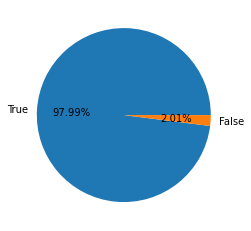

In [74]:
pie_feature('visible', "")

In [72]:
data

,address_required,amount_raised,analytics_count,background,comments_count,comments_enabled,committed,currency,currency_display,date_end,date_end_extra_time,date_goal_raised,date_start,delivery,description_ca,description_de,description_fr,description_funding_ca,description_funding_de,description_funding_fr,description_funding_nl,description_funding_pt,description_nl,description_pt,description_yourself_ca,description_yourself_de,description_yourself_fr,description_yourself_nl,description_yourself_pt,discussions_thread_id,fans_count,finished,goal,goal_raised,id,image,is_in_extra_time,location,lowest_contribution_amount,main_image,main_tag,name_ca,name_de,name_fr,name_nl,name_pt,nb_days,nb_products_sold,news_count,orders_count,owner,payment_methods,percent,phone_number_required,required_personal_id_number,resource_uri,rewards,sharing_urls,slug,sponsorships_count,subtitle_ca,subtitle_de,subtitle_fr,subtitle_nl,subtitle_pt,supporters_count,time_left,time_left_short,timezone,type,urls,video,visible,news_per_days
0,False,520,0,"{'color': '', 'id': 1333735, 'url': 'https://s...",12,everyone,8,EUR,€,2019-12-15T22:59:00Z,NaN,NaN,2019-10-22T00:00:00Z,"{'address_required': False, 'date_delivery': N...",NaN,NaN,<p><strong>DESCRIPTION : </strong></p>\n<p>Mon...,NaN,NaN,<p>Le financement me permettra de lancer la pr...,NaN,NaN,NaN,NaN,NaN,NaN,"<p><img src=""https://d2homsd77vx6d2.cloudfront...",NaN,NaN,693309.0,16,True,50,False,96490,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,False,"{'city': 'Montigny-lès-Metz', 'country': 'FR',...",1.0,{'230x126': 'https://img.ulule.com/display/179...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,Pull bio éco-responsable pour sauver les balei...,NaN,NaN,50.0,8,2,7,{'absolute_url': 'https://www.ulule.com/onaori...,"['card', 'creditcard', 'saving']",16,False,False,https://api.ulule.com/v1/projects/96490,"[{'address_required': True, 'available': True,...","{'ca': 'https://fr.ulule.com/onaori/', 'de': '...",onaori,0,NaN,NaN,10% reversés pour l'achat d'un sweartshirt,NaN,NaN,7,NaN,NaN,Europe/Paris,1,{'web': {'checkout': 'https://www.ulule.com/pr...,NaN,True,0.040000
1,False,3415,0,"{'color': '', 'id': 1542930, 'url': 'https://s...",65,everyone,3415,EUR,€,2020-09-30T21:59:00Z,NaN,2020-09-30T07:20:33.974135Z,2020-08-03T00:00:00Z,"{'address_required': False, 'date_delivery': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,745895.0,50,True,3000,True,111165,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,False,"{'city': 'Bolzano - Bozen', 'country': 'IT', '...",1.0,{'230x126': 'https://img.ulule.com/display/6e6...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,NaN,NaN,NaN,NaN,52,7,52,{'absolute_url': 'https://www.ulule.com/lilian...,"['card', 'creditcard', 'paypal', 'saving']",113,False,False,https://api.ulule.com/v1/projects/111165,"[{'address_required': False, 'available': True...","{'ca': 'https://it.ulule.com/i-falchi/', 'de':...",i-falchi,0,NaN,NaN,NaN,NaN,NaN,46,NaN,NaN,Europe/Paris,2,{'web': {'checkout': 'https://www.ulule.com/pr...,NaN,True,0.000000
2,False,480,0,"{'color': '#adc4e3', 'id': 1329113}",6,everyone,6,EUR,€,2019-10-30T22:59:00Z,NaN,2019-10-29T14:48:38.352985Z,2019-10-17T00:00:00Z,"{'address_required': False, 'date_delivery': N...",NaN,NaN,<p>En avant première découvrez notre collectio...,NaN,NaN,<p>Moea a fêté cette année ces 2ans! 2ans de d...,NaN,NaN,NaN,NaN,NaN,NaN,"<p>Notre collection 2020 s'intitule Pachamama,...",NaN,NaN,692232.0,6,True,5,True,96208,https://s3-eu-west-1.amazonaws.com/com.ulule.m...,False,"{'city': 'Montpellier', 'country': 'FR', 'full...",1.0,{'230x126': 'https://img.ulule.com/display/fa9...,{'absolute_url': 'https://www.ulule.com/catego...,NaN,NaN,Pré-ventes Moea Swimwear!,NaN,NaN,20.0,6,0,6,{'absolute_url': 'https://www.ulule.com/evaber...,"['card', 'creditcard', 'saving']",120,False,False,https://api.ulule.com/v1/projects/96208,"[{'address_required': True, 'available': True,...",{'ca': 'https://fr.ulule.com/preventes_moeasw

In [ ]:
datadd